In [ ]:
!pip install pyclesperanto_prototype

c:\Users\aubhi\anaconda3\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with GPU in their name. Using Intel(R) Iris(R) Plus Graphics instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


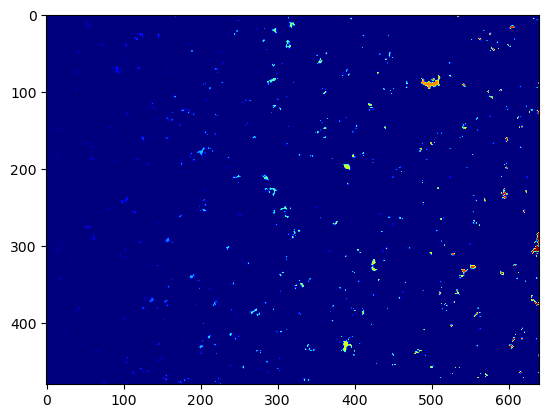

In [1]:
import cv2
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

# Load your IHC image
image = cv2.imread('ki67.jpg', cv2.IMREAD_GRAYSCALE)  # Load image as grayscale

# Initialize clEsperanto
cle.select_device('GPU')

# Preprocess your image (e.g., thresholding using Otsu's method)
thresholded = cle.threshold_otsu(image)

# Segment your image (e.g., connected components labeling)
labeled = cle.connected_components_labeling_box(thresholded)

# Post-process your segmentation (optional, depending on your needs)
# For example, removing small objects, filling holes, etc.
# ...

# Visualize your segmentation
plt.imshow(labeled, cmap='jet')
plt.show()


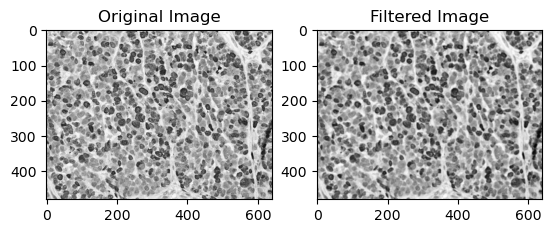

In [2]:
import skimage
from skimage import io, color, filters
import matplotlib.pyplot as plt

# Load an image
image = io.imread('ki67.jpg')

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply a Gaussian filter
filtered_image = filters.gaussian(gray_image, sigma=1)

# Display the original and filtered images
plt.subplot(1,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.show()

In [1]:
"""
https://www.wouterbulten.nl/blog/tech/peso-dataset-whole-slide-image-prosate-cancer/
"""
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity


In [3]:

# Separate the individual stains from the IHC image
def color_separate(ihc_rgb):

    #RGB image to HED skimage method
    ihc_hed = rgb2hed(ihc_rgb)
    
    #Convert individual channels to ubyte
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))

    #Optional fun exercise of combining H and DAB stains into a single image with fluorescence look
    
    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

# Cast the two channels into an RGB image, as the blue and green channels
#Convert to ubyte for easy saving as image to local drive
    zdh = img_as_ubyte(np.dstack((null, d, h))) #DAB in green and H in Blue

    return (ihc_h, ihc_e, ihc_d, zdh)

(-0.5, 639.5, 479.5, -0.5)

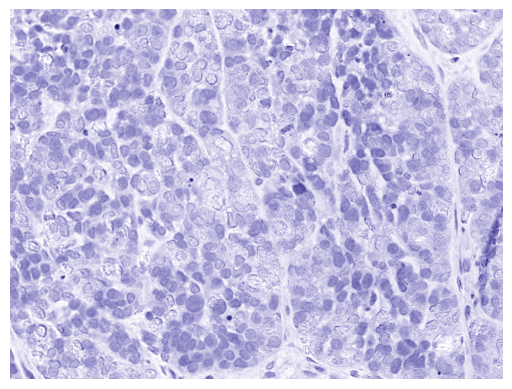

In [8]:
ihc_rgb =io.imread("ki67.jpg")

plt.imshow(ihc_rgb)
plt.axis("off")

H,E,D,HD = color_separate(ihc_rgb)
plt.imsave('H_img.jpg', H)
plt.imsave('DAB_img.jpg', D)

plt.imshow(H)
plt.axis("off")

c:\Users\aubhi\anaconda3\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with RTX in their name. Using Intel(R) Iris(R) Plus Graphics instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


Used GPU:  <Intel(R) Iris(R) Plus Graphics on Platform: Intel(R) OpenCL HD Graphics (2 refs)>


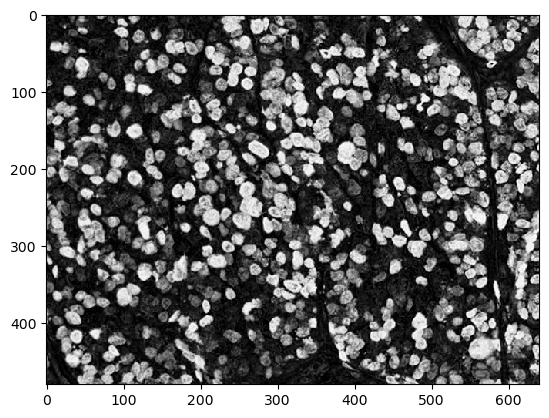

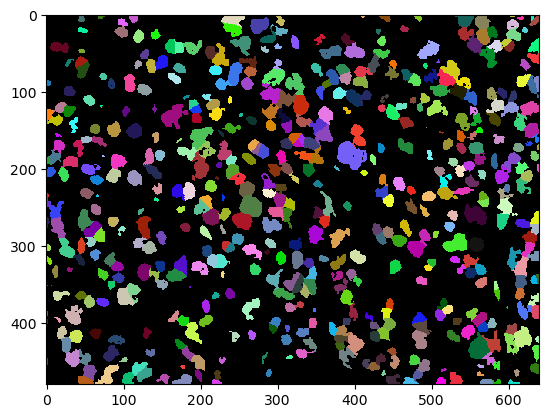

            label  original_label  bbox_min_x  bbox_min_y  bbox_min_z  \
count  533.000000      533.000000  533.000000  533.000000       533.0   
mean   267.000000      267.000000  328.015015  230.063797         0.0   
std    154.008117      154.008117  194.145630  137.369995         0.0   
min      1.000000        1.000000    0.000000    0.000000         0.0   
25%    134.000000      134.000000  167.000000  116.000000         0.0   
50%    267.000000      267.000000  325.000000  225.000000         0.0   
75%    400.000000      400.000000  506.000000  344.000000         0.0   
max    533.000000      533.000000  637.000000  474.000000         0.0   

       bbox_max_x  bbox_max_y  bbox_max_z  bbox_width  bbox_height  ...  \
count  533.000000  533.000000       533.0  533.000000   533.000000  ...   
mean   342.782379  245.266418         0.0   15.767355    16.202627  ...   
std    194.266220  137.347153         0.0    5.922615     6.123435  ...   
min      1.000000    1.000000         0.0 

In [9]:
import pyclesperanto_prototype as cle

# select a specific OpenCL / GPU device and see which one was chosen
device = cle.select_device('RTX')
print("Used GPU: ", device)

input_image = np.invert(D[:,:,2])
plt.imshow(input_image, cmap='gray')
#Before segmenting the image, need to push it to GPU memory. For visualisation purposes we crop out a sub-region:
input_gpu = cle.push(input_image)


cle.imshow(input_gpu)
    
sigma_spot_detection = 3
sigma_outline = 1

segmented = cle.voronoi_otsu_labeling(input_gpu, spot_sigma=sigma_spot_detection, 
                                      outline_sigma=sigma_outline)

cle.imshow(segmented, labels=True)

   
statistics = cle.statistics_of_labelled_pixels(input_gpu, segmented) 

import pandas as pd
table = pd.DataFrame(statistics)    

print(table.describe())
print(table.info())

#### Trying unet for the peso dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

c:\Users\aubhi\anaconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import os
import cv2
import numpy as np

In [3]:
# Paths to your data
image_dir= r"D:\Images\images_4"
mask_dir= r"D:\Images\masks_4"

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

### This method is not working using CV2

In [19]:
#cv2.IMREAD_IGNORE_ORIENTATION = 1e9  # or None to remove the limit (does not work)
def load_and_resize(image_path, target_size=(512, 512)):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    return img_resized

In [20]:
images = np.array([load_and_resize(os.path.join(image_dir, f)) for f in image_files])
masks = np.array([load_and_resize(os.path.join(mask_dir, f)) for f in mask_files])

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:79: error: (-215:Assertion failed) pixels <= CV_IO_MAX_IMAGE_PIXELS in function 'cv::validateInputImageSize'


#### Trying Pillow instead

In [4]:
from PIL import Image

In [6]:
Image.MAX_IMAGE_PIXELS = None # Disable DecompressionBombError
def load_and_resize(image_path, target_size=(512, 512)):
    with Image.open(image_path) as img:
        img_resized = img.resize(target_size, Image.ANTIALIAS)
        return np.array(img_resized)

images = np.array([load_and_resize(os.path.join(image_dir, f)) for f in image_files])
masks = np.array([load_and_resize(os.path.join(mask_dir, f)) for f in mask_files])


C:\Users\aubhi\AppData\Local\Temp\ipykernel_17804\1347499884.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(target_size, Image.ANTIALIAS)


#### This is working, but takes way too long. Using imagerio

In [1]:
import imageio

In [2]:
def resize_images(input_dir, output_dir, target_size=(512, 512)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_files = sorted(os.listdir(input_dir))

    for image_file in image_files:
        input_path = os.path.join(input_dir, image_file)
        output_path = os.path.join(output_dir, image_file)

        # Load and resize the image
        img = imageio.imread(input_path)
        img_resized = imageio.imresize(img, target_size)

        # Save the resized image
        imageio.imsave(output_path, img_resized)


In [ ]:
!pip install imagecodecs


In [ ]:
# Paths to your data
resized_image_dir = r'D:\Images\resize_images_4'
resized_mask_dir = r'C:\data\resize_masks_4'

# Resize images and masks
resize_images(image_dir, resized_image_dir)
resize_images(mask_dir, resized_mask_dir)

#### Bad news! Have to use Pil but use one image at a time

In [23]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None
def resize_images(input_dir, output_dir, target_size=(512, 512)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_files = sorted(os.listdir(input_dir))

    for image_file in image_files:
        input_path = os.path.join(input_dir, image_file)
        output_path = os.path.join(output_dir, image_file)

        # Load and resize the image
        with Image.open(input_path) as img:
            img_resized = img.resize(target_size, Image.ANTIALIAS)

            # Save the resized image
            img_resized.save(output_path)

# Paths to your data
image_dir = r"D:\Images\images_4"
mask_dir = r"D:\Images\masks_4"
resized_image_dir = r"D:\Images\resized_images_4"
resized_mask_dir = r"D:\Images\resized_masks_4"

# Resize images and masks
resize_images(image_dir, resized_image_dir)
resize_images(mask_dir, resized_mask_dir)

C:\Users\aubhi\AppData\Local\Temp\ipykernel_12424\4188229719.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(target_size, Image.ANTIALIAS)


In [24]:
from PIL import Image
import os

def check_image_type(image_path):
    with Image.open(image_path) as img:
        # Convert to numpy array
        img_array = np.array(img)
        # Check the shape of the array
        if len(img_array.shape) == 2 or (len(img_array.shape) == 3 and img_array.shape[2] == 1):
            print(f"The image at {image_path} is grayscale.")
        elif len(img_array.shape) == 3 and img_array.shape[2] == 3:
            print(f"The image at {image_path} is RGB.")
        else:
            print(f"The image at {image_path} has an unrecognized format. Shape: {img_array.shape}")

# Example usage:
image_dir = r"D:\Images\resized_images_4"  # replace with the path to your images directory
image_files = os.listdir(image_dir)

# Check the first image in the directory
first_image_path = os.path.join(image_dir, image_files[0])
check_image_type(first_image_path)


The image at D:\Images\resized_images_4\pds_2_HE.tif is RGB.


In [25]:
def load_data(img_dir, mask_dir):
    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    images = [np.array(Image.open(os.path.join(img_dir, f))) for f in img_files]
    masks = [np.array(Image.open(os.path.join(mask_dir, f)).convert('L'))[..., np.newaxis] for f in mask_files]
    
    return np.array(images), np.array(masks)

# Paths to your data
image_dir_train = r"D:\Images\resized_images_4"
mask_dir_train = r"D:\Images\resized_masks_4"

# Load the resized images and masks
images, masks = load_data(image_dir_train, mask_dir_train)

print(f'Shape of images: {images.shape}')
print(f'Shape of masks: {masks.shape}')

# ... rest of your code ...



Shape of images: (10, 512, 512, 3)
Shape of masks: (10, 512, 512, 1)


#### Mask array lacks a channel

In [26]:
def load_data(img_dir, mask_dir):
    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    images = [np.array(Image.open(os.path.join(img_dir, f))) for f in img_files]
    masks = [np.array(Image.open(os.path.join(mask_dir, f)).convert('L'))[..., np.newaxis] for f in mask_files]
    
    return np.array(images), np.array(masks)

# Paths to your data
image_dir_train = r"D:\Images\resized_images_4"
mask_dir_train = r"D:\Images\resized_masks_4"

# Load the resized images and masks
images, masks = load_data(image_dir_train, mask_dir_train)

print(f'Shape of images: {images.shape}')
print(f'Shape of masks: {masks.shape}')

Shape of images: (10, 512, 512, 3)
Shape of masks: (10, 512, 512, 1)


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def create_unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    
    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    
    # Expanding Path
    u5 = UpSampling2D((2, 2))(c4)
    merge5 = concatenate([u5, c3], axis=-1)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge5)
    
    u6 = UpSampling2D((2, 2))(c5)
    merge6 = concatenate([u6, c2], axis=-1)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge6)
    
    u7 = UpSampling2D((2, 2))(c6)
    merge7 = concatenate([u7, c1], axis=-1)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge7)
    
    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    
    return model

# Instantiate and compile the U-Net model
model = create_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

# Print the model summary
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 128, 128, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 64, 64, 64)  0           ['conv2d_32[0][0]']              
 )                                                                                          

In [30]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Data augmentation
data_gen_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(x_train, seed=seed, batch_size=16)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=16)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

# Create an instance of the U-Net model
unet_model_instance = create_unet_model(input_size=(512, 512, 3))

# Compile the model
unet_model_instance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True )

# Train the model
history = unet_model_instance.fit(train_generator, steps_per_epoch=len(x_train)//16, epochs=20)

# Evaluate the model on the test data
scores = unet_model_instance.evaluate(x_test, y_test, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# To visualize the performance of the trained U-Net model
# Get the model prediction
predictions = unet_model_instance.predict(x_test, verbose=1)

# Plot the result on a test image
n = 10  # assuming you have at least 10 images in the test set
plt.figure(figsize=(10, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])  # Adjusted to handle RGB images
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(512, 512))  # Adjusted to match resized image dimensions
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Epoch 1/20


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

#### There are some sort of a problem associated with the train_function:  The train_generator being used in the fit method should be providing data in the correct format, but there may be an issue with how the data is being formatted or processed.

To better debug this issue, a custom generator function will replace the zip function currently being used to combine the image_generator and mask_generator. This custom generator will format the data as tuples of (input_batch, target_batch), which is the expected format for training

In [31]:
def custom_generator(image_generator, mask_generator):
    while True:
        image_batch, mask_batch = next(image_generator), next(mask_generator)
        yield image_batch, np.expand_dims(mask_batch, -1)  # Add an extra dimension to the masks


In [32]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Data augmentation
data_gen_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(x_train, seed=seed, batch_size=16)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=16)

# Create the custom generator
train_generator = custom_generator(image_generator, mask_generator)

# Create an instance of the U-Net model
unet_model_instance = create_unet_model(input_size=(512, 512, 3))

# Compile the model
unet_model_instance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

# Train the model
history = unet_model_instance.fit(train_generator, steps_per_epoch=len(x_train)//16, epochs=20)

# Evaluate the model on the test data
scores = unet_model_instance.evaluate(x_test, np.expand_dims(y_test, -1), verbose=1)  # Add an extra dimension to y_test

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# To visualize the performance of the trained U-Net model
# Get the model prediction
predictions = unet_model_instance.predict(x_test, verbose=1)

# Plot the result on a test image
n = 10  # assuming you have at least 10 images in the test set
plt.figure(figsize=(10, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])  # Adjusted to handle RGB images
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(512, 512))  # Adjusted to match resized image dimensions
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Epoch 1/20


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

#### Trying a simpler model

In [34]:
def create_unet_model_simpler(input_size=(512, 512, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    conv6 = Conv2D(1, (1, 1), activation='sigmoid')(conv5)  # Single channel output for binary segmentation

    model = Model(inputs, conv6)
    return model

# Assume `images` and `masks` are your data
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Create an instance of the simpler U-Net model
unet_model_simpler = create_unet_model_simpler()

# Compile the model
unet_model_simpler.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_simpler = unet_model_simpler.fit(x_train, np.expand_dims(y_train, -1), batch_size=16, epochs=20, validation_split=0.1)

# Evaluate the model on the test data
scores_simpler = unet_model_simpler.evaluate(x_test, np.expand_dims(y_test, -1), verbose=1)

print('Test loss:', scores_simpler[0])
print('Test accuracy:', scores_simpler[1])


Epoch 1/20
1/1 [==============================] - 9s 9s/step - loss: 5.3037 - accuracy: 0.6674 - val_loss: 92.9436 - val_accuracy: 0.1897
Epoch 2/20
1/1 [==============================] - 6s 6s/step - loss: 76.4347 - accuracy: 0.2859 - val_loss: 31.6409 - val_accuracy: 0.1961
Epoch 3/20
1/1 [==============================] - 7s 7s/step - loss: 25.9149 - accuracy: 0.2918 - val_loss: 7.9067 - val_accuracy: 0.7737
Epoch 4/20
1/1 [==============================] - 7s 7s/step - loss: 11.6962 - accuracy: 0.6599 - val_loss: 10.7911 - val_accuracy: 0.7753
Epoch 5/20
1/1 [==============================] - 7s 7s/step - loss: 15.9593 - accuracy: 0.6607 - val_loss: 9.8129 - val_accuracy: 0.7753
Epoch 6/20
1/1 [==============================] - 7s 7s/step - loss: 14.5099 - accuracy: 0.6608 - val_loss: 7.2140 - val_accuracy: 0.7753
Epoch 7/20
1/1 [==============================] - 7s 7s/step - loss: 10.7107 - accuracy: 0.6608 - val_loss: 3.9605 - val_accuracy: 0.7753
Epoch 8/20
1/1 [================

#### Accuracy is around 70%. Trying a k-fold cv

In [36]:
from sklearn.model_selection import KFold

In [38]:
# Define the number of folds
n_folds = 5

# Create a KFold object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Assuming `images` and `masks` are your data
# Initialize variables to hold overall scores
total_loss = 0
total_accuracy = 0

# Loop over each fold
for train_index, val_index in kf.split(images):
    # Split the data into training and validation sets for this fold
    x_train, x_val = images[train_index], images[val_index]
    y_train, y_val = masks[train_index], masks[val_index]

    # Create an instance of the simpler U-Net model
    unet_model_simpler = create_unet_model_simpler()

    # Compile the model
    unet_model_simpler.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history_simpler = unet_model_simpler.fit(x_train, np.expand_dims(y_train, -1), batch_size=16, epochs=20, validation_data=(x_val, np.expand_dims(y_val, -1)))

    # Evaluate the model on the validation data
    scores_simpler = unet_model_simpler.evaluate(x_val, np.expand_dims(y_val, -1), verbose=1)
    
    # Update overall scores
    total_loss += scores_simpler[0]
    total_accuracy += scores_simpler[1]

# Calculate and print average loss and accuracy
average_loss = total_loss / n_folds
average_accuracy = total_accuracy / n_folds

print('Average loss:', average_loss)
print('Average accuracy:', average_accuracy)


Epoch 1/20
1/1 [==============================] - 10s 10s/step - loss: 44.5526 - accuracy: 0.2739 - val_loss: 22.6360 - val_accuracy: 0.6085
Epoch 2/20
1/1 [==============================] - 8s 8s/step - loss: 19.7818 - accuracy: 0.6750 - val_loss: 15.7623 - val_accuracy: 0.6085
Epoch 3/20
1/1 [==============================] - 7s 7s/step - loss: 13.6550 - accuracy: 0.6750 - val_loss: 5.5349 - val_accuracy: 0.6084
Epoch 4/20
1/1 [==============================] - 7s 7s/step - loss: 4.8145 - accuracy: 0.6748 - val_loss: 8.3990 - val_accuracy: 0.3473
Epoch 5/20
1/1 [==============================] - 7s 7s/step - loss: 9.4209 - accuracy: 0.2820 - val_loss: 4.0268 - val_accuracy: 0.3493
Epoch 6/20
1/1 [==============================] - 7s 7s/step - loss: 4.5454 - accuracy: 0.2839 - val_loss: 1.1912 - val_accuracy: 0.6270
Epoch 7/20
1/1 [==============================] - 9s 9s/step - loss: 0.9757 - accuracy: 0.6944 - val_loss: 0.6164 - val_accuracy: 0.6819
Epoch 8/20
1/1 [==================

#### Visualize the data

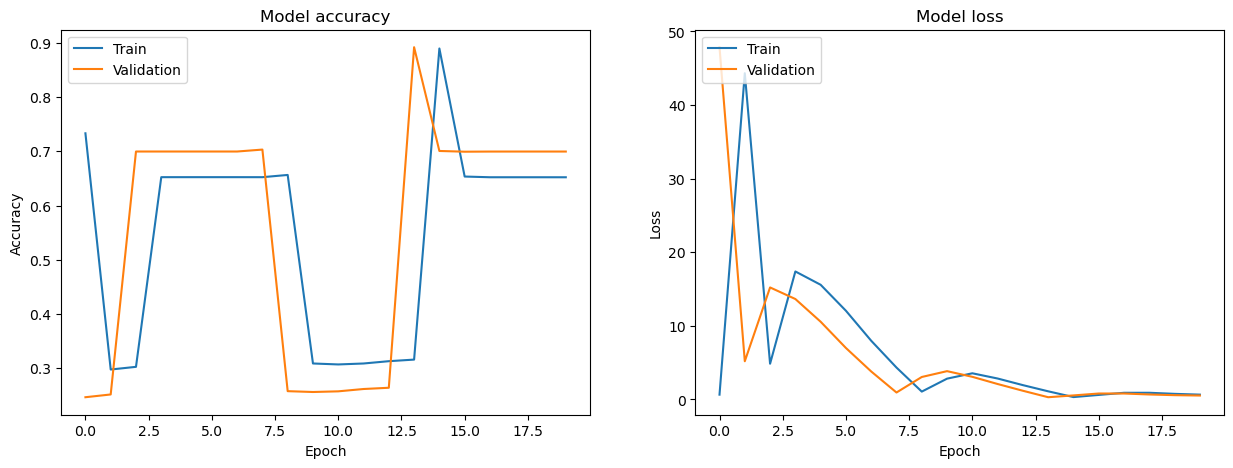

In [39]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Assuming history_simpler is the history object from your training
plot_history(history_simpler)


1/1 [==============================] - 1s 583ms/step


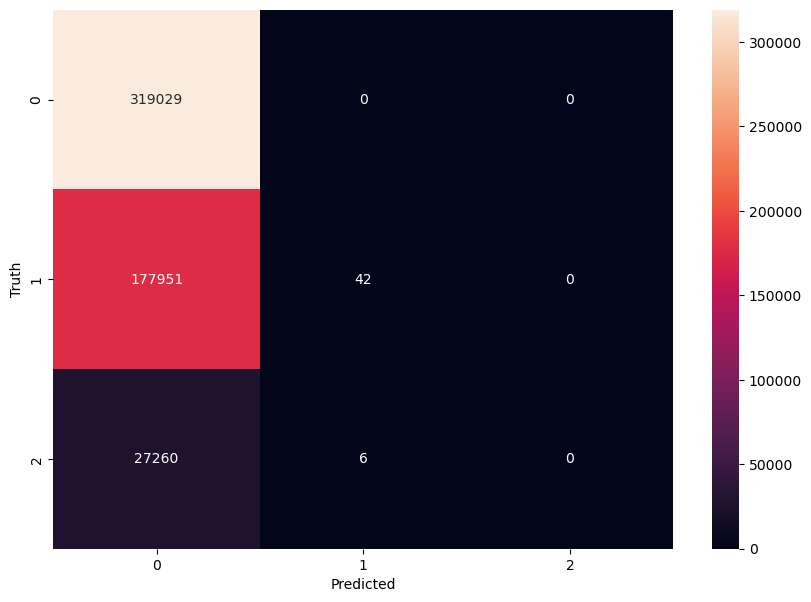

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_test is your ground truth and predictions are the model's predictions
predictions = unet_model_simpler.predict(x_test)
predictions = (predictions > 0.5).astype(np.uint8)  # Assuming binary classification and a sigmoid activation

# Flatten the arrays for confusion matrix
cm = confusion_matrix(y_test.flatten(), predictions.flatten())

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for ROC curve
fpr, tpr, thresholds = roc_curve(y_test.flatten(), predictions.flatten())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### ROC does not apply for multi class:
make them binary

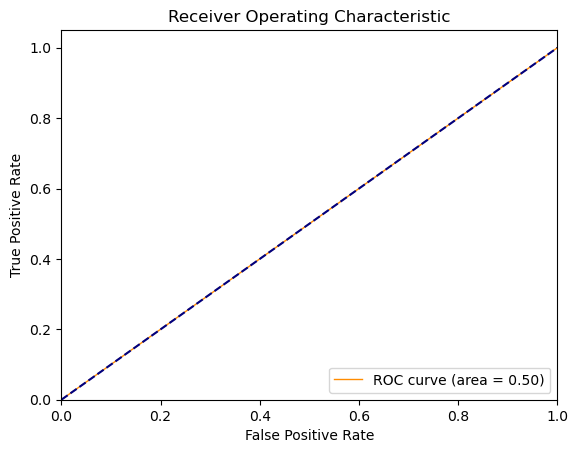

In [43]:
from sklearn.metrics import roc_curve, auc
# Convert multiclass to binary
y_test_binary = np.where(y_test > 0, 1, 0)
predictions_binary = np.where(predictions > 0, 1, 0)

# Now compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary.flatten(), predictions_binary.flatten())
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


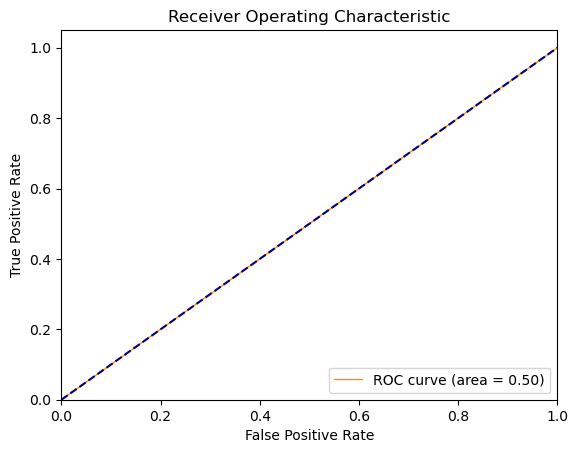

In [45]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert multiclass to binary (1 to 0, 2 to 1)
y_test_binary = np.where(y_test == 1, 0, np.where(y_test == 2, 1, -1))
predictions_binary = np.where(predictions == 1, 0, np.where(predictions == 2, 1, -1))

# Get the indices where class label is not -1 (i.e., ignore class 0)
non_zero_indices = np.where(y_test_binary != -1)

# Select only the elements where the class label is not -1
y_test_binary = y_test_binary[non_zero_indices]
predictions_binary = predictions_binary[non_zero_indices]

# Now compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary.flatten(), predictions_binary.flatten())
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 1s 574ms/step


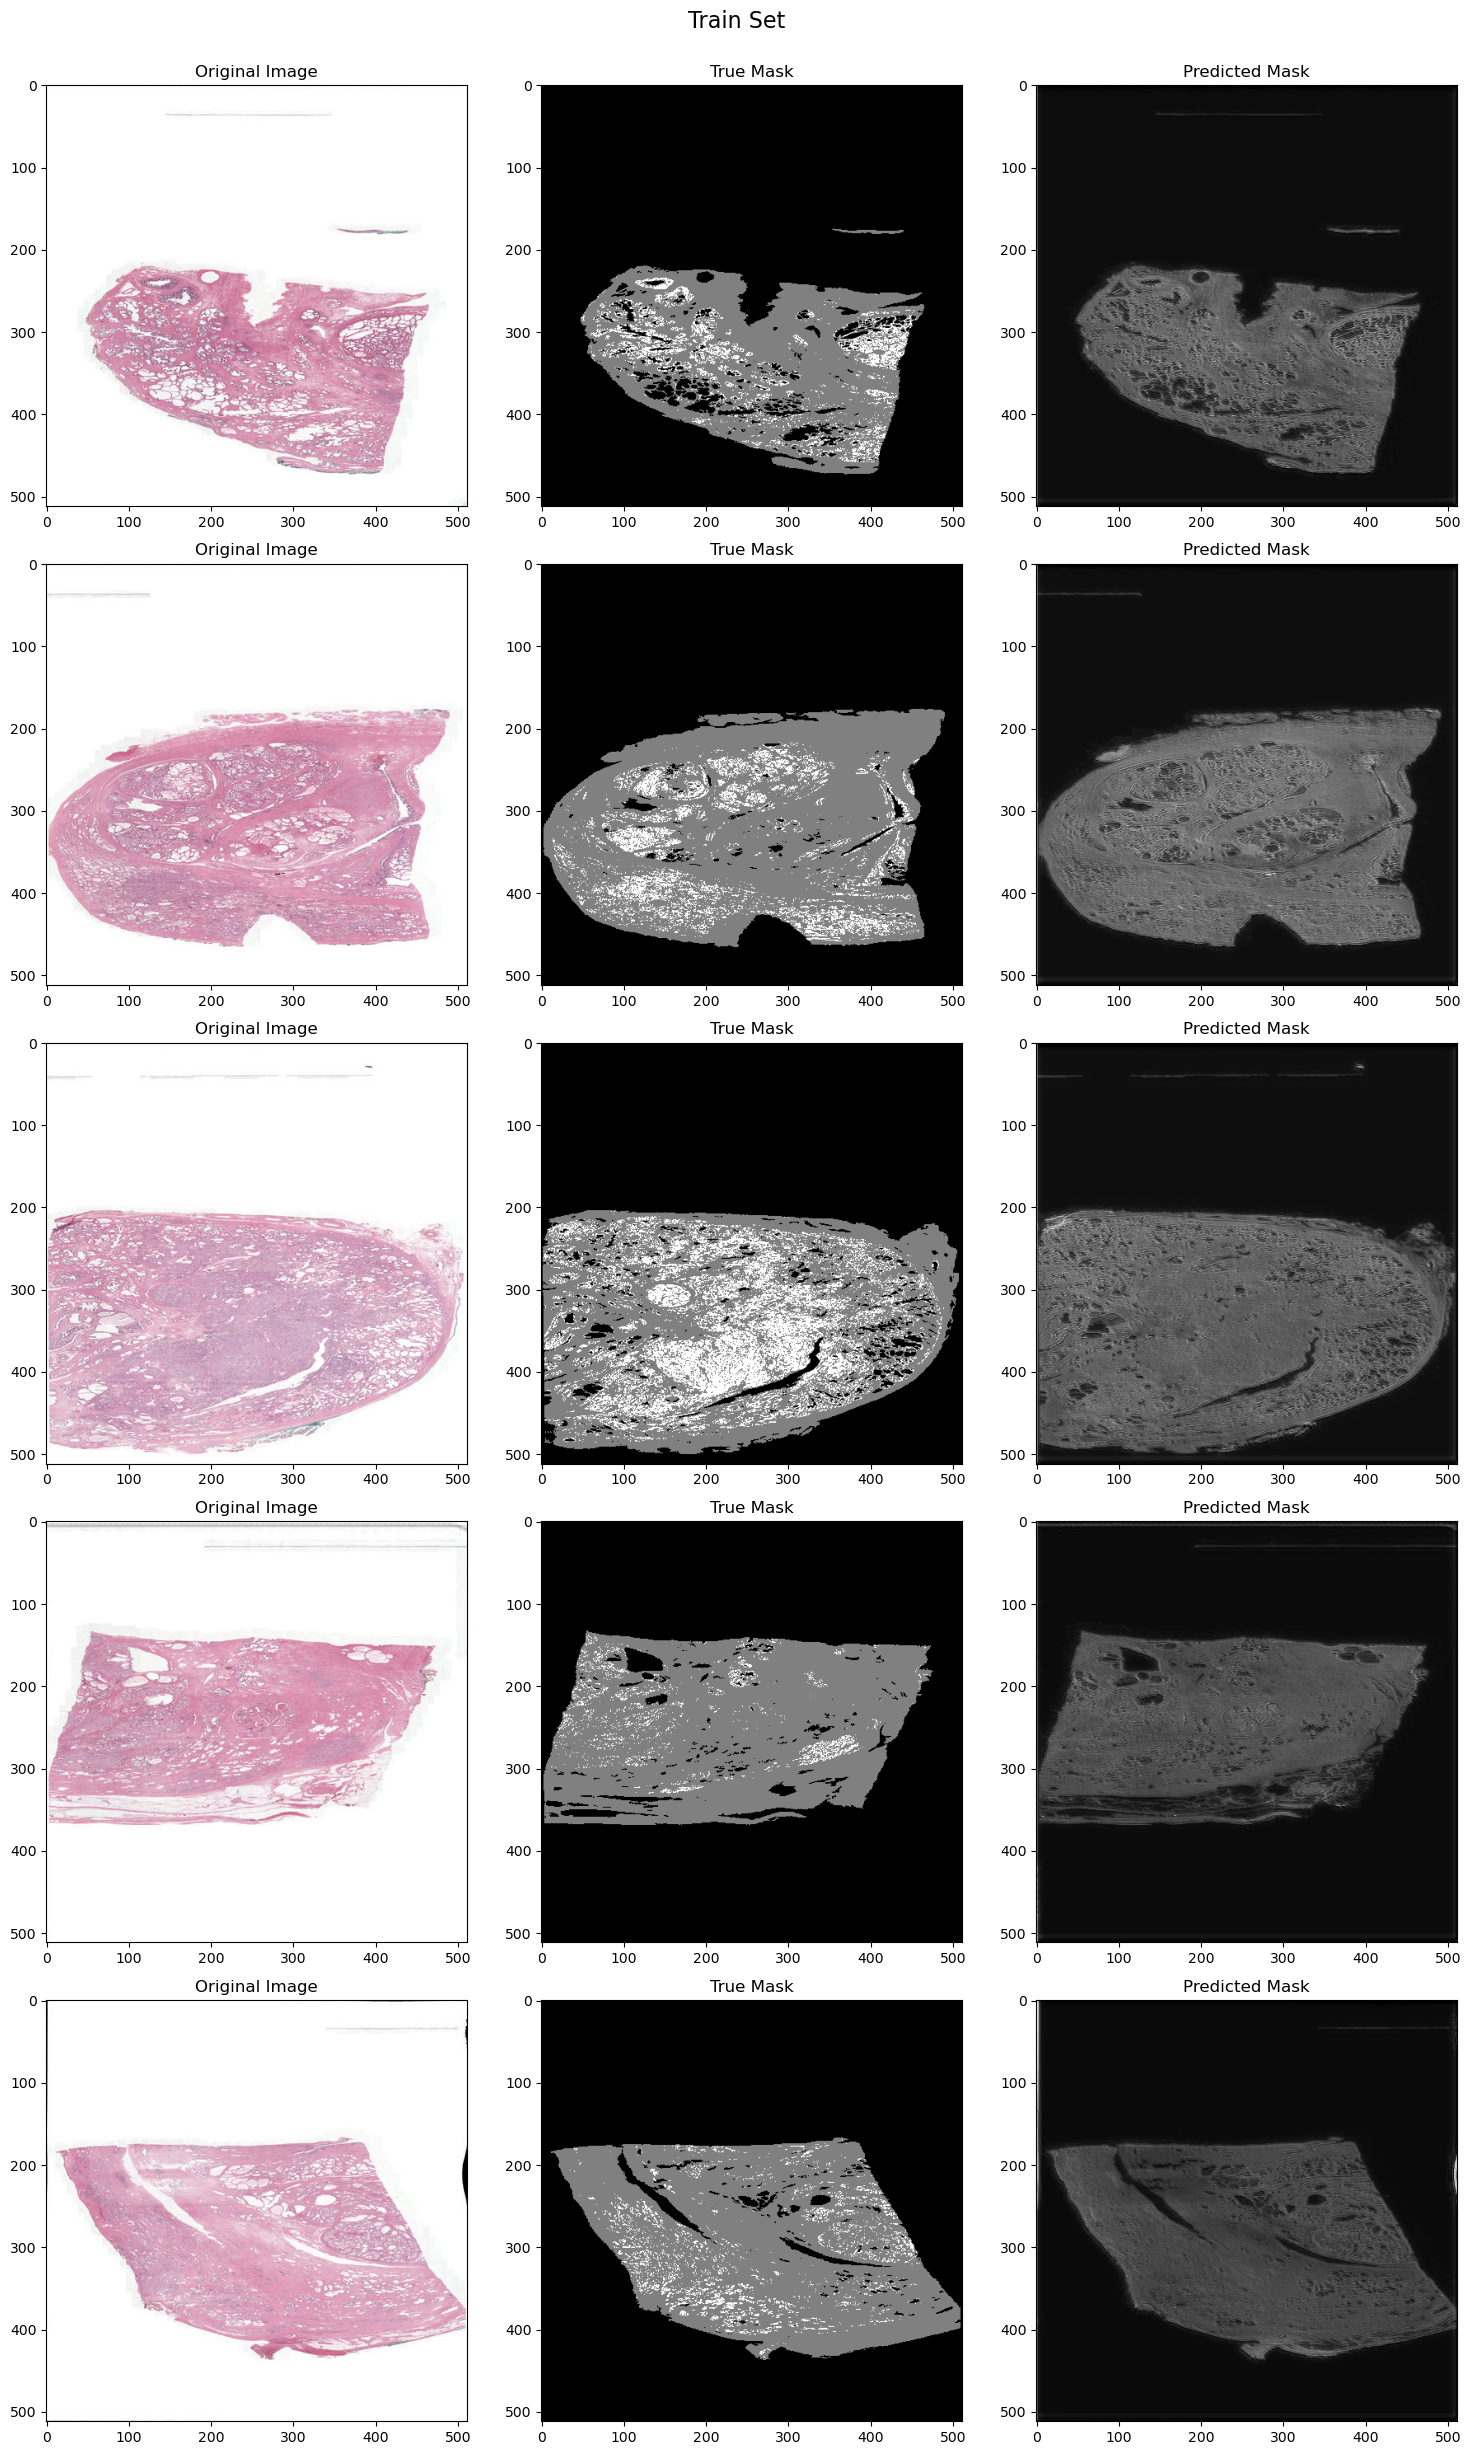

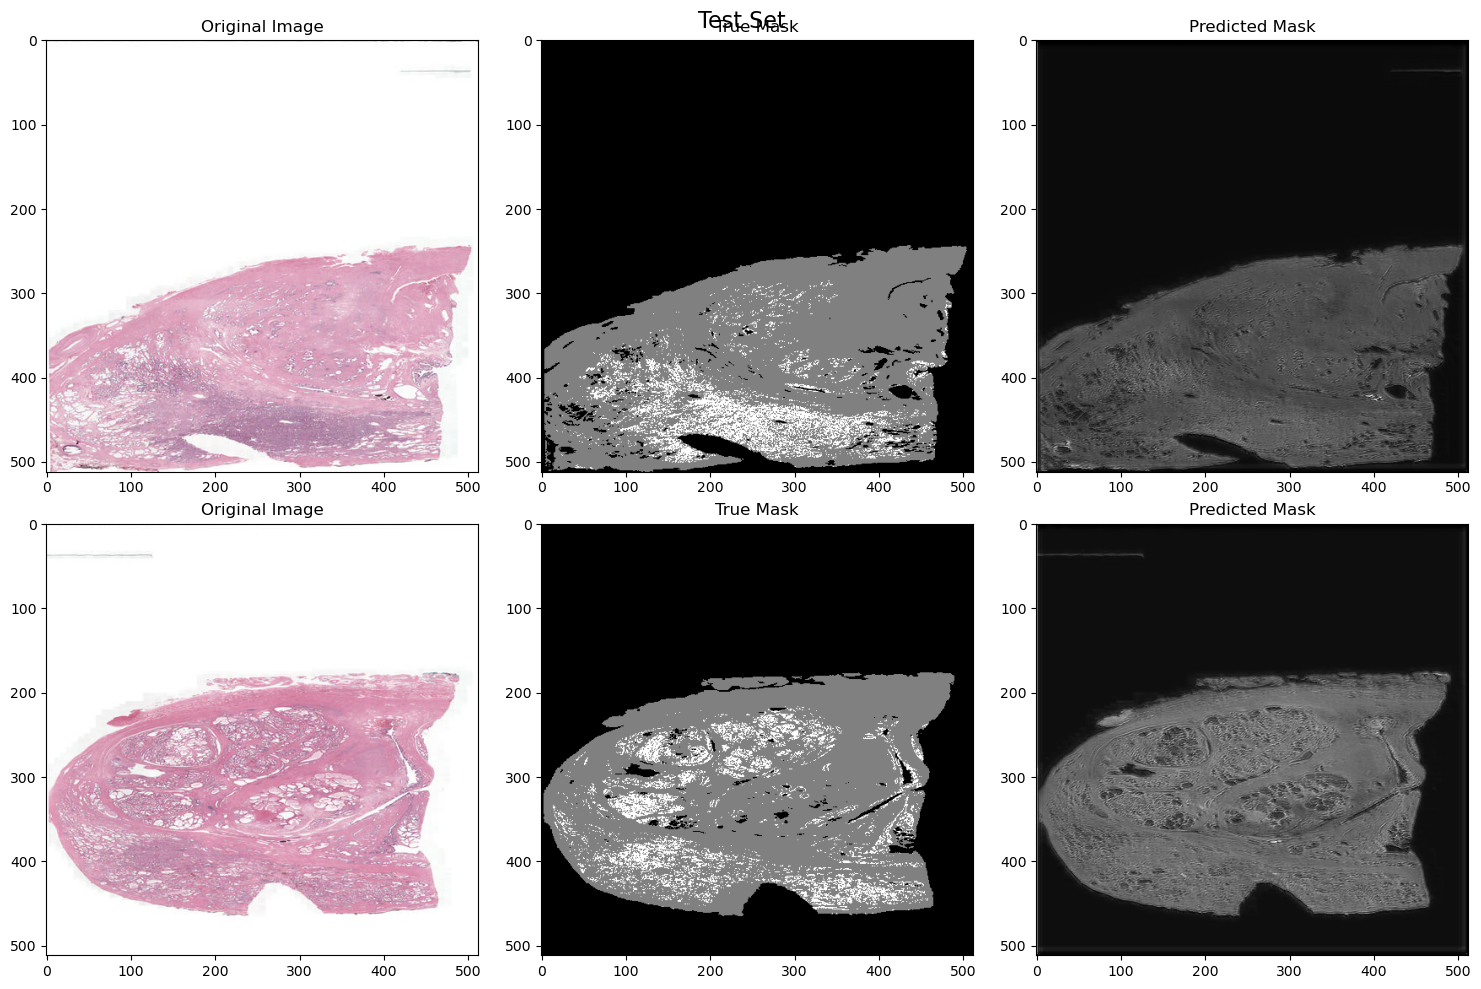

In [46]:
def plot_images_masks(images, true_masks, predicted_masks, title):
    n = len(images)  # Number of images/masks
    plt.figure(figsize=(15, 5*n))
    
    for i in range(n):
        # Display original image
        ax = plt.subplot(n, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        
        # Display true mask
        ax = plt.subplot(n, 3, i*3 + 2)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        
        # Display predicted mask
        ax = plt.subplot(n, 3, i*3 + 3)
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Get predictions for both train and test sets
train_predictions = unet_model_simpler.predict(x_train)
test_predictions = unet_model_simpler.predict(x_test)

# Assume you want to visualize the first 5 images/masks from the train and test sets
n_visualize = 5

# Plot train images, true masks, and predicted masks
plot_images_masks(x_train[:n_visualize], y_train[:n_visualize], train_predictions[:n_visualize], title='Train Set')

# Plot test images, true masks, and predicted masks
plot_images_masks(x_test[:n_visualize], y_test[:n_visualize], test_predictions[:n_visualize], title='Test Set')


In [47]:
#save the model
unet_model_simpler.save('unet_model_simpler.h5')

1/1 [==============================] - 2s 2s/step


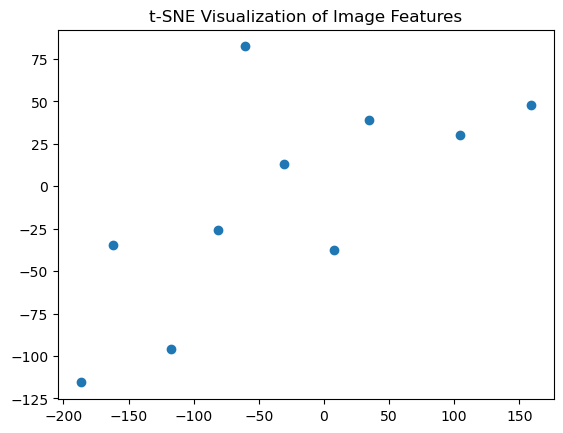

In [53]:
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.manifold import TSNE

# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet')

def extract_features(img_array, model):
    # Resize the images to 224x224
    img_array_resized = np.array([cv2.resize(img, (224, 224)) for img in img_array])
    # Preprocess the images
    img_array_preprocessed = preprocess_input(img_array_resized)
    # Get features
    features = model.predict(img_array_preprocessed)
    # Flatten the features
    features_flatten = features.reshape(features.shape[0], -1)
    return features_flatten

# Assume images is your dataset of images
features = extract_features(images, base_model)

# Perform t-SNE dimensionality reduction with a lower perplexity value
tsne = TSNE(n_components=2, perplexity=5, random_state=0)  # Adjust perplexity here
tsne_result = tsne.fit_transform(features)

# Plot t-SNE result
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE Visualization of Image Features')
plt.show()